In [1]:
import pandas as pd
import numpy as np

In [3]:
from datasets import load_dataset

HF_USERNAME = "LukeGPT88"
PROJECT_NAME = "patient-doctor-text-classifier"
SUB_PROJECT_NAME = "eng"
DATASET_NAME = f"{HF_USERNAME}/{PROJECT_NAME}-{SUB_PROJECT_NAME}-dataset"
TASK = f"{PROJECT_NAME}-{SUB_PROJECT_NAME}"

dataset = load_dataset(DATASET_NAME)

Found cached dataset parquet (/home/luca/.cache/huggingface/datasets/LukeGPT88___parquet/LukeGPT88--patient-doctor-text-classifier-eng-dataset-969009eecb9a6735/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 24746
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8249
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8249
    })
})

In [ ]:
len(dataset['train']['text'])

## MEMORY SIZE FOR EACH STRING

In [ ]:
import sys

size_in_bytes = []

for text in dataset['train']['text']:
  size_in_bytes.append(sys.getsizeof(text) - sys.getsizeof(""))

print(f"Total Size of text strings: {sum(size_in_bytes)} bytes")
print(f"Average Size for each string: {sum(size_in_bytes)/len(dataset['train']['text'])} bytes")

## Confusion Matrix

In [4]:
from transformers import pipeline
classifier = pipeline("text-classification", model=f"{HF_USERNAME}/{TASK}")

/home/luca/anaconda3/envs/HF/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
pred_list = []
id2label = {0: "PATIENT", 1: "DOCTOR", 2: "NEUTRAL"}

def mapping(idx):
  label = id2label.get(idx)
  return label

for text in dataset['test']['text']:
  res = classifier(text)
  pred_list.append(res[0]['label'])

true_list = list(map(mapping, dataset['test']['label']))


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[9.88e-01 3.72e-04 1.11e-02]
 [1.38e-03 9.93e-01 5.53e-03]
 [1.61e-02 3.00e-03 9.81e-01]]


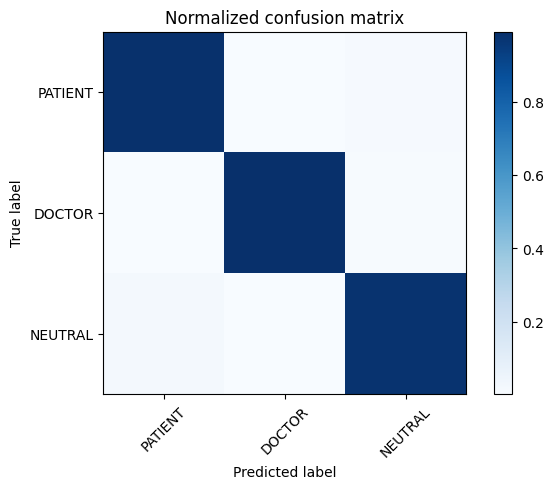

In [9]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_list, pred_list)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, id2label.values(), 
        title='Normalized confusion matrix')

plt.show()

## TRANSLATION TASK

In [ ]:
from deep_translator import GoogleTranslator

texts = dataset['train']['text']
res = GoogleTranslator(source='auto', target='it').translate_batch(texts)

In [ ]:
from deep_translator import GoogleTranslator

data = {}
data['en'] = dataset['train']['text']
for lang in ['it']:
  examples_list = []
  for idx, text in enumerate(dataset['train']['text']):
    res = GoogleTranslator(source='auto', target=lang).translate(text)
    examples_list.append(res)
    print(idx)
  data[lang] = examples_list

df = pd.DataFrame(data)
df.to_csv('patient-doctor-text-classifier-it-dataset.csv')